In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import glob
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
from sklearn.metrics import r2_score
import seaborn as sns
from theano import tensor as tt
from nilearn import datasets
from nilearn.signal import clean
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiLabelsMasker
from sklearn.decomposition import NMF
from nilearn.image import resample_to_img
import nibabel as nib
import arviz as az
import warnings
from itertools import combinations
import matplotlib
from nilearn import plotting, surface
from nilearn import datasets as ds
from sklearn.decomposition import FastICA
from factor_analyzer import FactorAnalyzer
from nilearn.datasets import fetch_surf_fsaverage


Initialize

In [ ]:
export_figures = True
PATH = "..."
scaler = StandardScaler()
imp = SimpleImputer(missing_values=999,strategy="median")

In [2]:
# Initialize plotting
matplotlib.rcParams["svg.fonttype"] = "none"
plt.rcParams.update({"font.family": "Helvetica Neue"})
cm = 1 / 2.54  # centimeters in inches

color = ['#3f005c', '#ffa600']
my_colors = []
for c in color:
    my_colors.append(matplotlib.colors.to_rgb(c))

Prepare data

In [ ]:
# Load lesion load data
lesion_load = pd.read_csv(PATH + "data.csv")
lesion_load = lesion_load.drop(columns="Unnamed: 0")
lesion_bilat = lesion_load.iloc[:1401].copy()
lesion_bilat = lesion_bilat.rename(columns={"0": "Left"})
lesion_bilat["Right"] = np.array(lesion_load.iloc[1401:])

In [ ]:
# Load behavioral data
Behav = pd.read_excel(PATH + 'behavioral.xlsx')
Behav = Behav[np.invert((lesion_bilat!=0).all(axis=1))]  # excluding patients with bilateral lesions
# Imputing missing values with median
Behav_imp = pd.DataFrame(imp.fit_transform(Behav))
Behav_imp.columns = Behav.columns
# Average time for TMT A and B
Behav_imp['TMT_Time_zscore_neg'] = np.mean([Behav_imp.TMT_A_Time_zscore_neg, Behav_imp.TMT_B_Time_zscore_neg], axis=0)

In [ ]:
# Extra behavioral measures
Behav_extra = pd.read_excel(PATH + 'behav_extended.xlsx')
Behav_extra = Behav_extra[Behav_extra.ID.isin(Behav_imp.ID)]
Behav_extra_imp = pd.DataFrame(imp.fit_transform(Behav_extra))
Behav_extra_imp.columns = Behav_extra.columns
Behav_imp['SemanticFluency'] = scaler.fit_transform(Behav_extra_imp.Semanticfluencyanimal.values.reshape(-1, 1))
Behav_imp['PhonemicFluency'] = scaler.fit_transform(Behav_extra_imp.Phonemicfluency_total.values.reshape(-1, 1))
Behav_imp['DigitSymbolCoding'] = scaler.fit_transform(Behav_extra_imp.DigitSymbolCoding_correct.values.reshape(-1, 1))
Behav_imp = Behav_imp.drop(columns=["ID","Cohort"])
# Scaling the total infarct volume
Total_infarct_volume_scaled = scaler.fit_transform(np.array(Behav_imp.Total_infarct_volume).reshape(-1, 1))
Behav_imp["Total_infarct_volume_scaled"] = Total_infarct_volume_scaled
# Collapsing the data
Behav_imp_collapsed = pd.concat([Behav_imp, Behav_imp], axis=0)
Behav_imp_collapsed.index = range(0,2160)

In [ ]:
# Load lesion masks
subject_names = glob.glob(PATH + '/lesionmaps/*',)
subject_names = sorted(subject_names)
# Load atlas
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm', symmetric_split=True)
cortical_mask = dataset.maps
cortical_labels = dataset.labels
dataset = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')
subcortical_mask = dataset.maps
subcortical_labels = dataset.labels
# Edit the labels
cortical_labels = pd.DataFrame(cortical_labels)
cortical_labels = cortical_labels.drop(index=[0,93,94])
subcortical_labels = pd.DataFrame(subcortical_labels)
subcortical_labels = subcortical_labels.drop(index=[0,1,2,3,12,13,14])

In [ ]:
# Loading mapped to cortical and subcortical regions
cortical = pd.read_csv(PATH + "/cortical.csv")
cortical = cortical.drop(columns="Unnamed: 0")
subcortical = pd.read_csv(PATH + "/subcortical.csv")
subcortical = subcortical.drop(columns="Unnamed: 0")

# resample one sub to the cortical mask
cortical_resampled_stat_img = resample_to_img(cortical_mask, subject_names[0], interpolation='nearest')
# resample one subject to subcortical mask
subcortical_resampled_stat_img = resample_to_img(subcortical_mask, subject_names[0], interpolation='nearest')
# count voxels in a region
cortical_count_labels = np.bincount(cortical_resampled_stat_img.get_data().astype(np.int64).ravel())
subcortical_count_labels = np.bincount(subcortical_resampled_stat_img.get_data().astype(np.int64).ravel())

In [ ]:
# Extracting the labels
cortical_count_labels = pd.DataFrame(cortical_count_labels)
cortical_count_labels = np.array(cortical_count_labels.drop(index=[0,93,94])).ravel()
subcortical_count_labels = pd.DataFrame(subcortical_count_labels)
subcortical_count_labels = np.array(subcortical_count_labels.drop(index=[0, ])).ravel()

# number of lesion in each region
cortical_lesion_count_absolute = cortical*cortical_count_labels
subcortical_lesion_count_absolute = subcortical*subcortical_count_labels
subcortical_lesion_count_absolute = subcortical_lesion_count_absolute.drop(columns=["0","1","2","11","12","13"])

In [ ]:
# Renaming the columns
cortical_lesion_count_absolute.columns = cortical_labels
subcortical_lesion_count_absolute.columns = subcortical_labels

new_columns = []
for parcel in range(len(cortical_lesion_count_absolute.columns)):
        new_columns.append(cortical_lesion_count_absolute.columns[parcel][0].replace(" ", "_"))
cortical_lesion_count_absolute.columns = new_columns

new_columns = []
for parcel in range(0, len(subcortical_lesion_count_absolute.columns)):
        new_columns.append(subcortical_lesion_count_absolute.columns[parcel][0].replace(" ", "_"))
subcortical_lesion_count_absolute.columns = new_columns

subcortical_lesion_count_absolute = subcortical_lesion_count_absolute.drop(columns=['Brain-Stem'])

# reduce to non-bilateral
cortical_lesion_count_absolute = cortical_lesion_count_absolute[np.invert((lesion_bilat!=0).all(axis=1))]

In [ ]:
# Splitting the data into left and right hemisphere
cortical_lesion_left = cortical_lesion_count_absolute.iloc[:,range(0,94,2)]
cortical_lesion_left.loc[:,"Left_hemisphere"] = 0
cortical_lesion_right = cortical_lesion_count_absolute.iloc[:,range(1,95,2)]
cortical_lesion_right.loc[:,"Left_hemisphere"] = 1

for hem, hem_name in zip([cortical_lesion_right, cortical_lesion_left], ["Right_", "Left_"]):
    new_columns = []
    for parcel in range(0, len(hem.columns[:-1])):
            new_columns.append(hem.columns[parcel].replace(hem_name, ""))
    new_columns.append("Left_hemisphere")
    hem.columns = new_columns

cortical_lesion_collapsed = pd.concat([cortical_lesion_left, cortical_lesion_right])

In [ ]:
# Splitting the data into left and right hemisphere
subcortical_lesion_count_absolute = subcortical_lesion_count_absolute[np.invert((lesion_bilat!=0).all(axis=1))]

subcortical_lesion_left = subcortical_lesion_count_absolute.iloc[:,range(0,7,1)]
subcortical_lesion_left.loc[:,"Left_hemisphere"] = 0
subcortical_lesion_right = subcortical_lesion_count_absolute.iloc[:,range(7,14,1)]
subcortical_lesion_right.loc[:,"Left_hemisphere"] = 1

for hem, hem_name in zip([subcortical_lesion_right, subcortical_lesion_left], ["Right_", "Left_"]):
    new_columns = []
    for parcel in range(0, len(hem.columns[:-1])):
            new_columns.append(hem.columns[parcel].replace(hem_name, ""))
    new_columns.append("Left_hemisphere")
    hem.columns = new_columns

subcortical_lesion_collapsed = pd.concat([subcortical_lesion_left, subcortical_lesion_right])

In [ ]:
lesions_collapsed_all = pd.concat([cortical_lesion_collapsed, subcortical_lesion_collapsed], axis=1)
lesions_collapsed_hemisphere = lesions_collapsed_all["Left_hemisphere"].copy()
lesions_collapsed_hemisphere = np.array(lesions_collapsed_hemisphere)
lesions_collapsed_all = lesions_collapsed_all.drop(columns="Left_hemisphere")


In [ ]:
hemisphere_idx = lesions_collapsed_hemisphere[:,0]
n_hemispheres = len(np.unique(lesions_collapsed_hemisphere))
n_components = 10

Prepare covariates

In [ ]:
# Age mean scaled
Age_mean_scaled = Behav_imp["Age"] - Behav_imp["Age"].mean()
Age_mean_scaled = np.concatenate((Age_mean_scaled, Age_mean_scaled))
Age_mean_scaled_2 = np.array(Age_mean_scaled * Age_mean_scaled)

Behav_imp_collapsed["Sex_1_m"] = Behav_imp_collapsed["Sex"].replace(1,0)
Behav_imp_collapsed["Sex_1_m"] = Behav_imp_collapsed["Sex_1_m"].replace(2,1)
Sex_m = np.int64(np.array(Behav_imp_collapsed["Sex_1_m"]))
Behav_imp_collapsed["Sex_1_w"] = Behav_imp_collapsed["Sex"].replace(2,0)
Sex_w = np.int64(np.array(Behav_imp_collapsed["Sex_1_w"]))

Age_Sex_m = Age_mean_scaled * Sex_m
Age_Sex_w = Age_mean_scaled * Sex_w

Lesion_vol_scaled = np.array(Behav_imp_collapsed.Total_infarct_volume_scaled)

In [ ]:
Education_mean_scaled = Behav_imp["Education_years"] - Behav_imp["Education_years"].mean() 
Education_mean_scaled = np.concatenate((Education_mean_scaled, Education_mean_scaled))
Education_mean_scaled = np.array(Education_mean_scaled)

IQ_mean_scaled = Behav_imp["IQCODE"] - Behav_imp["IQCODE"].mean()
IQ_mean_scaled = np.concatenate((IQ_mean_scaled , IQ_mean_scaled ))
IQ_mean_scaled = np.array(IQ_mean_scaled )

In [ ]:
# Outlier detection and removal
X1 = Behav_imp_collapsed.MMSE_total_zscore.values
X2 = Behav_imp_collapsed.ReyComplexFigureTestCopy_zscore.values
X3 = Behav_imp_collapsed.BostonNamingTest_zscore.values
X4 = Behav_imp_collapsed.Seoul_Verbal_Learning_Test_immediate_recall_total_zscore.values
X5 = Behav_imp_collapsed.TMT_Time_zscore_neg.values
X6 = Behav_imp_collapsed.SemanticFluency.values
X7 = Behav_imp_collapsed.PhonemicFluency.values
X8 = Behav_imp_collapsed.DigitSymbolCoding.values
X = np.array([X1, X2, X3, X4, X5, X6, X7, X8])

# Input names
cat_names = ['MiniMentalStateExam', 'ReyComplexFigure', 'BostonNaming',
             'SeoulVerbalLearning', 'TrailMaking', 'SemanticFluency',
             'PhonemicFluency', 'DigitSymbolCoding']

In [36]:
# NMF log nmb of lesions na 10 komponent
nmf = NMF(n_components=10, init='random', random_state=0)
lesions_collapsed_all_nmf_abs_log = nmf.fit_transform(np.log(lesions_collapsed_all+1))

Factor analysis

In [ ]:
# Transform input variables
n_comp = 4

fa = FactorAnalyzer(n_factors=n_comp, rotation="varimax")
X_star = fa.fit_transform(X.T)
A_ = fa.loadings_

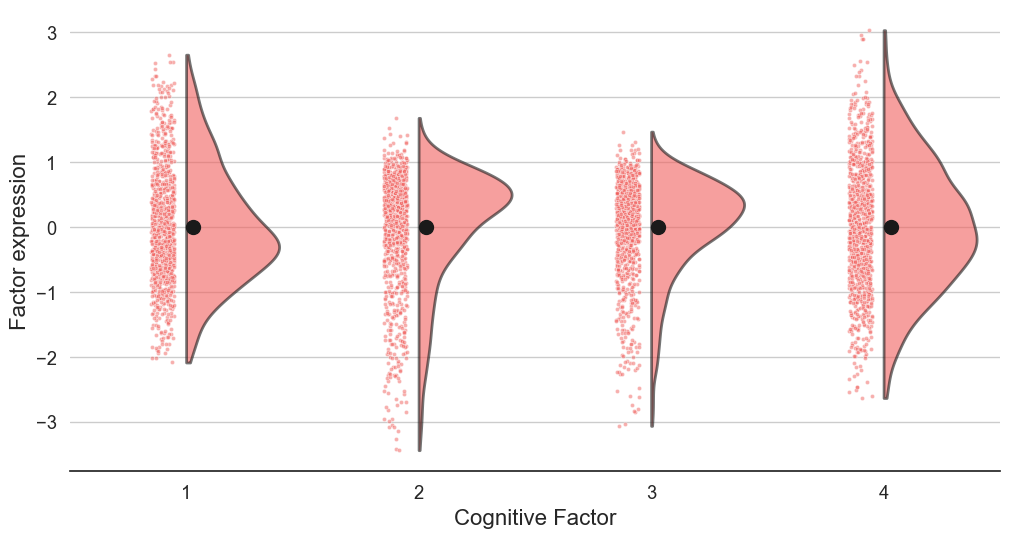

In [38]:
# Lesion scores
sns.set_theme(style="white", palette='colorblind', font_scale=1.2)
fig, ax = plt.subplots(1, figsize=(12, 6))
color_list = sns.color_palette("tab10", n_colors=4)
color = sns.color_palette("magma", n_colors=2)[1]
data = np.array((X_star[:1039, :] + X_star[1039:, :])/2).T
# Plot violiplot
v1 = ax.violinplot(data.T, vert=True, showextrema=False, points=5000, bw_method='scott', widths=0.8)
for b,c in zip(v1['bodies'], color_list):
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(color)
    b.set_edgecolor('k')
    b.set_linewidth(2)
    b.set_alpha(0.6)
# Plot points on the left    
for n in range(len(color_list)):
    sns.scatterplot(x=0.1*np.random.uniform(size=len(data[n]))+n+0.85, y=data[n],
                    color=color,
                    marker='.', sizes=5, alpha=0.5)
# Plot mean and standard error
for n in range(len(color_list)):
    ax.plot(n+1.03, np.mean(data[n]), 'k.', ms=20)
    
fontsize = 16
ax.set_ylabel('Factor expression', fontsize=fontsize)
ax.set_xlim([0.5, 4.5])
ax.set_xlabel('Cognitive Factor', fontsize=fontsize)
ax.set_xticks(np.arange(1, len(color_list)+1))
ax.set_title('', fontsize=fontsize+2)
sns.despine(left=True)
ax.yaxis.grid()
plt.show()


BHM

In [39]:
# Choose variable
var = 1
X_red = X_star[:, var-1]

In [40]:
# Univariate outcome without interaction
n_components = 10
with pm.Model() as hierarchical_all_parcels_education_log_model:
    b_all = ["b_1", "b_2", "b_3", "b_4", "b_5",
             "b_6", "b_7", "b_8", "b_9", "b_10"]
    mu = pm.Normal("a", mu=0, sd=1)
    sigma_b_hyper = pm.HalfCauchy("sigma_b_hyper",  1, shape=1)
    sigma_b_all = pm.HalfCauchy("sigma_b_all", sigma_b_hyper, shape=2)

    for i_component in range(n_components):
        cur_beta = pm.Normal(b_all[i_component], mu=0, sd=sigma_b_all, shape=2)
        mu = mu + cur_beta[hemisphere_idx] * lesions_collapsed_all_nmf_abs_log[:, i_component]

    cov1_beta = pm.Normal("cov1_lesions", mu=0, sd=10, shape=1)
    cov2_beta = pm.Normal("cov2_age", mu=0, sd=10, shape=1)
    cov3_beta = pm.Normal("cov3_age_2", mu=0, sd=10, shape=1)
    cov4_beta = pm.Normal("cov4_sex_m", mu=0, sd=1, shape=1)
    cov5_beta = pm.Normal("cov5_sex_w", mu=0, sd=1, shape=1)
    cov6_beta = pm.Normal("cov6_ed_years", mu=0, sd=5, shape=1)
    cov7_beta = pm.Normal("cov7_IQCode", mu=0, sd=1, shape=1)
    mu = mu + cov1_beta*Lesion_vol_scaled + cov2_beta*Age_mean_scaled + cov3_beta*Age_mean_scaled_2 + cov4_beta*Sex_m + \
        cov5_beta*Sex_w + cov6_beta * Education_mean_scaled + cov7_beta*IQ_mean_scaled

    # Model error
    eps = pm.HalfCauchy('eps',20)

    # Data likelihood
    TO_uv = pm.Normal('TO_uv', mu=mu, sd=eps, observed=X_red)

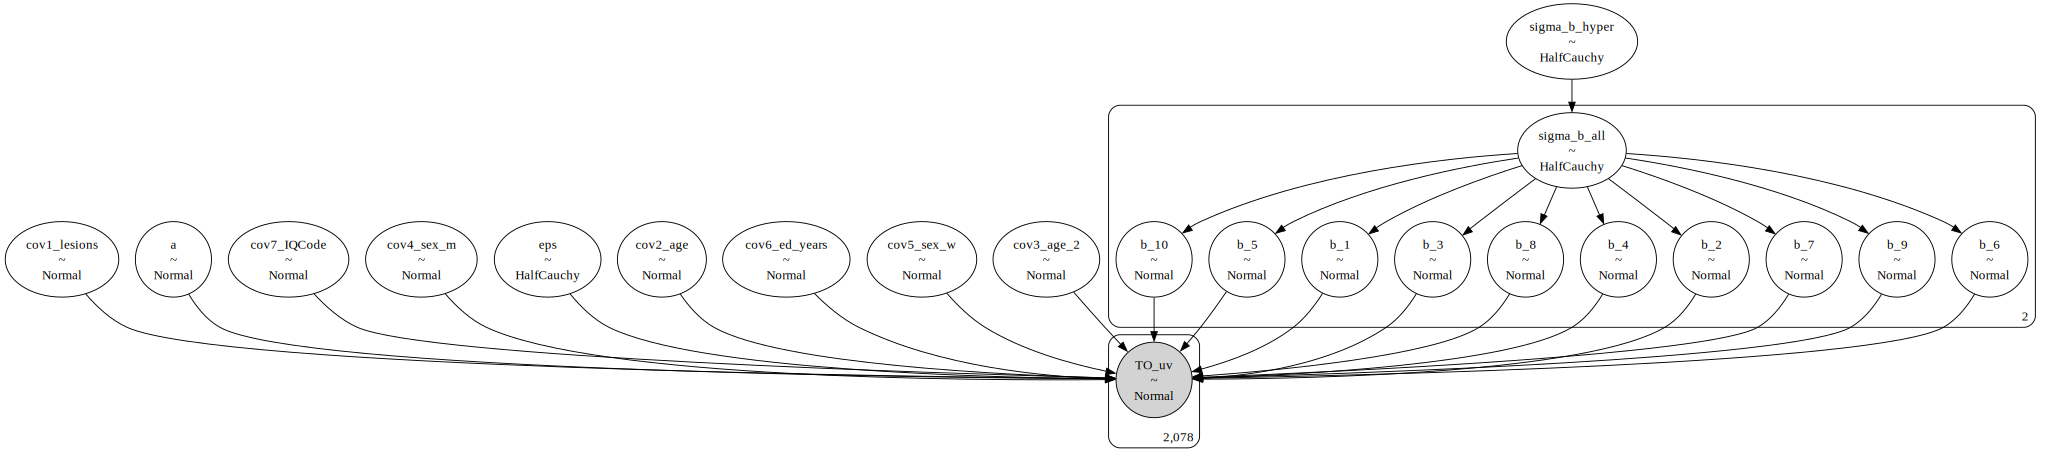

In [41]:
pm.model_to_graphviz(hierarchical_all_parcels_education_log_model)


In [ ]:
# Inference button (TM)!
with hierarchical_all_parcels_education_log_model:
    hierarchical_all_parcels_education_log_trace = pm.sample(draws=2000, n_init=1000, random_seed=1,
                                                             chains=4, cores=8, tune=1000, target_accept=0.99,
                                                             init="adapt_diag")

In [ ]:
pm.save_trace(hierarchical_all_parcels_education_log_trace,
              PATH + "/unimodal_fa_v" +str(var) + ".trace")


/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_76961/1647542691.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  axes = pm.traceplot(hierarchical_all_parcels_education_log_trace)
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


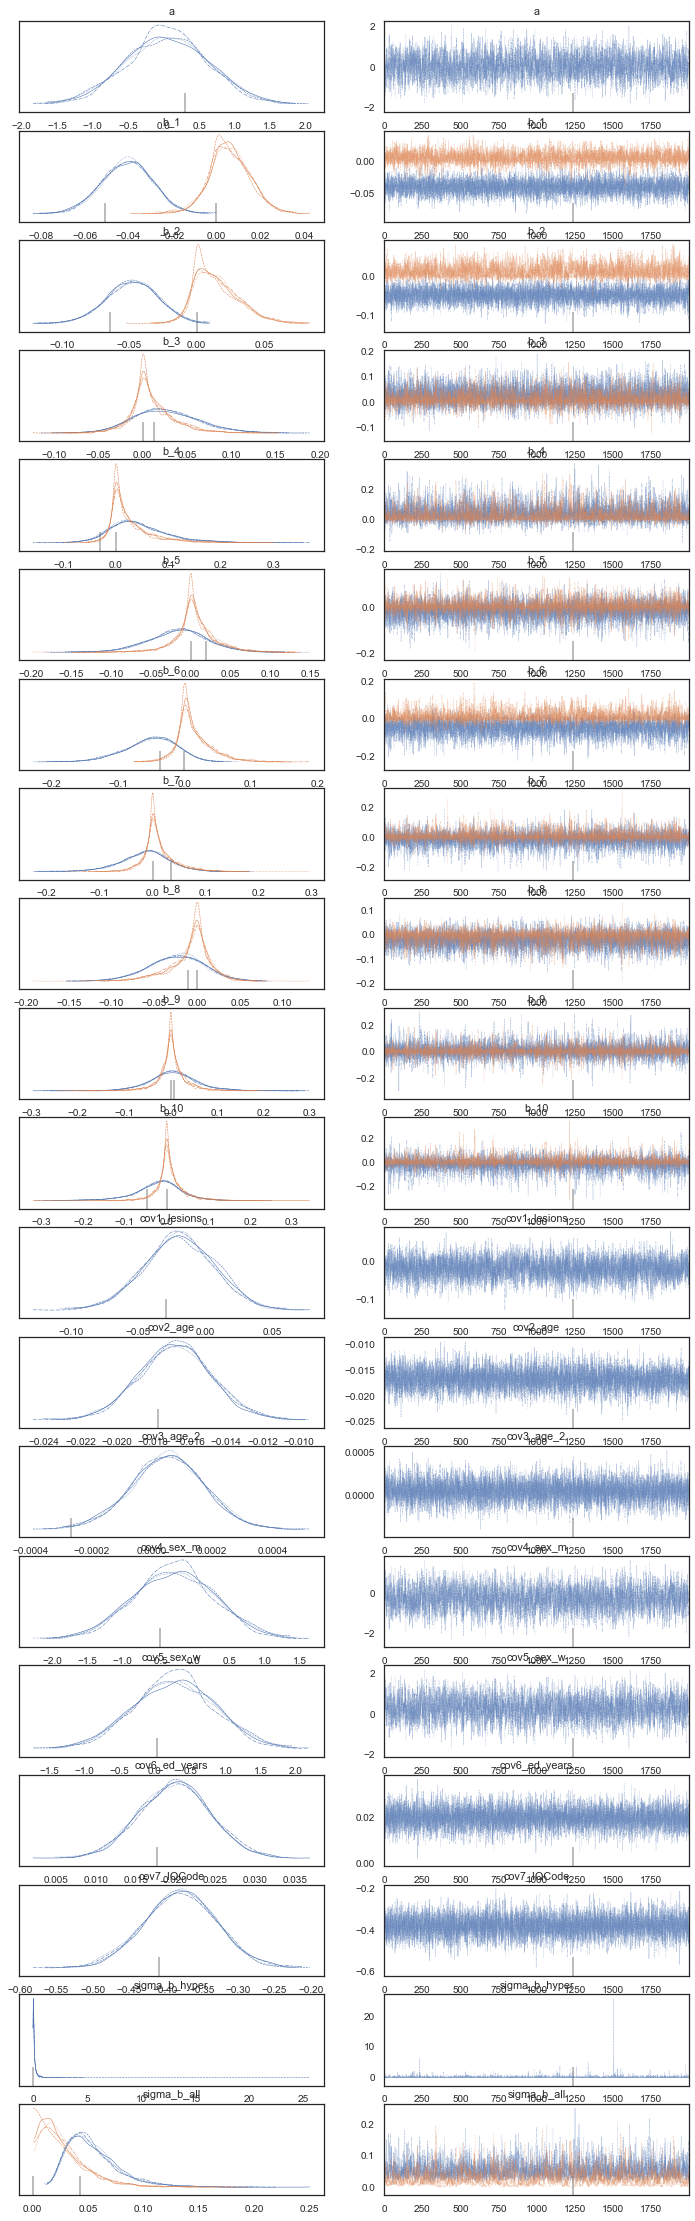

In [ ]:
sns.set(style="white",font_scale=2.5)
axes = pm.traceplot(hierarchical_all_parcels_education_log_trace)
fig = axes.ravel()[0].figure

In [ ]:
# left betas
b_left = []
b_left_distrib = []
for i in np.arange(1, 11):
    b_left.append(pd.DataFrame(hierarchical_all_parcels_education_log_trace[1000:]["b_%i" %i])[0].mean())
    b_left_distrib.append(pd.DataFrame(hierarchical_all_parcels_education_log_trace[1500:]["b_%i" %i])[0])
b_left = np.array(b_left)
b_left_distrib = np.array(b_left_distrib)

# right betas
b_right = []
b_right_distrib = []
for i in np.arange(1, 11):
    b_right.append(pd.DataFrame(hierarchical_all_parcels_education_log_trace[1000:]["b_%i" %i])[1].mean())
    b_right_distrib.append(pd.DataFrame(hierarchical_all_parcels_education_log_trace[1500:]["b_%i" %i])[1])
b_right = np.array(b_right)
b_right_distrib = np.array(b_right_distrib)

b_left_inverse = nmf.inverse_transform(b_left)
b_right_inverse = nmf.inverse_transform(b_right)

b_inverse = pd.DataFrame(b_left_inverse)
b_inverse = b_inverse.rename(columns={0: "left"})
b_inverse["right"] = pd.DataFrame(b_right_inverse)

b_nmf = pd.DataFrame(b_left)
b_nmf = b_nmf.rename(columns={0: "left"})
b_nmf["right"] = pd.DataFrame(b_right)

b_left_inverse_distrib = []
b_right_inverse_distrib = []
for i in range(np.shape(b_left_distrib)[1]):
    b_left_inverse_distrib.append(nmf.inverse_transform(b_left_distrib[:, i]))
    b_right_inverse_distrib.append(nmf.inverse_transform(b_right_distrib[:, i]))
b_left_inverse_distrib = np.array(b_left_inverse_distrib)
b_right_inverse_distrib = np.array(b_right_inverse_distrib)


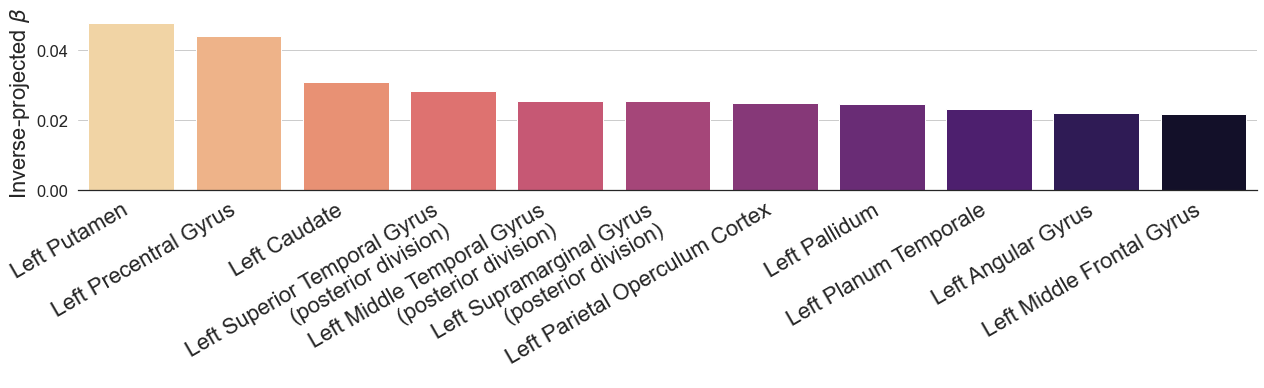

In [ ]:
def map_divergent(X, cmap):
    colors_div = sns.color_palette(cmap, n_colors=100)
    # minmax_scale = MinMaxScaler()
    X_min = np.min(X)
    X_max = np.max(X)
    X_scaled = ((X-X_min)/(X_max-X_min)*99).astype(int)
    clrs = []
    for c in X_scaled:
        clrs.append(colors_div[c])
    return clrs

a = (lesions_collapsed_all.columns)
my_regions = ['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus',
       'Middle Frontal Gyrus', 'Inferior Frontal Gyrus\n(pars_triangularis)',
       'Inferior Frontal Gyrus\n(pars opercularis)', 'Precentral Gyrus',
       'Temporal Pole', 'Superior Temporal Gyrus\n(anterior division)',
       'Superior Temporal Gyrus\n(posterior division)',
       'Middle Temporal Gyrus\n(anterior division)',
       'Middle Temporal Gyrus\n(posterior division)',
       'Middle Temporal Gyrus\n(temporooccipital part)',
       'Inferior Temporal Gyrus\n(anterior division)',
       'Inferior Temporal Gyrus\n(posterior division)',
       'Inferior Temporal Gyrus\n(temporooccipital part', 'Postcentral Gyrus',
       'Superior Parietal Lobule', 'Supramarginal Gyrus\n(anterior division)',
       'Supramarginal Gyrus\n(posterior division)', 'Angular Gyrus',
       'Lateral Occipital Cortex\n(superior division)',
       'Lateral Occipital Cortex\n(inferior division)', 'Intracalcarine Cortex',
       'Frontal Medial Cortex',
       'Juxtapositional Lobule Cortex',
       'Subcallosal Cortex', 'Paracingulate Gyrus',
       'Cingulate Gyrus\n(anterior division)',
       'Cingulate Gyrus\n(posterior division)', 'Precuneous Cortex',
       'Cuneal Cortex', 'Frontal Orbital Cortex',
       'Parahippocampal Gyrus\n(anterior division)',
       'Parahippocampal Gyrus\n(posterior division)', 'Lingual Gyrus',
       'Temporal Fusiform Cortex\n(anterior division)',
       'Temporal Fusiform Cortex\n(posterior division)',
       'Temporal Occipital\nFusiform Cortex', 'Occipital Fusiform Gyrus',
       'Frontal Operculum Cortex', 'Central Opercular Cortex',
       'Parietal Operculum Cortex', 'Planum Polare',
       'Heschl''s Gyrus', 'Planum Temporale',
       'Occipital Pole', 'Thalamus', 'Caudate', 'Putamen', 'Pallidum',
       'Hippocampus', 'Amygdala', 'Accumbens']
left_regions = ['Left ' + reg for reg in my_regions]
right_regions = ['Right ' + reg for reg in my_regions]

df = pd.DataFrame(np.abs(b_left_inverse), index = left_regions).transpose()
df[right_regions] = pd.DataFrame(np.abs(b_right_inverse)).transpose()
df = df.melt()
idx = np.argsort(-np.abs(df.value.values))
df = df.drop(df.index[np.argsort(idx)>10], axis=0)

sns.set_theme(style="white", palette='colorblind', font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(18, 6))
g = sns.barplot(x='variable', y='value', data=df, palette='magma_r', order=df.variable.values[[np.argsort(-np.abs(df.value.values))]])
g.set_xticklabels(g.get_xticklabels(), fontsize=22, rotation=30, horizontalalignment='right')
plt.tight_layout()
g.set_ylabel('Inverse-projected '+r'$\beta$', fontsize=22)
g.set_xlabel('')
sns.despine(left=True)
ax.yaxis.grid()
plt.show()

PPC in sample R^2: 9.000000


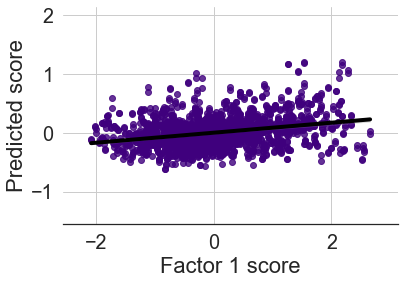

In [ ]:
# Predicted vs True Lin Regression
Y_ppc_insample = pm.sample_posterior_predictive(hierarchical_all_parcels_education_log_trace[500:],
                                                2000, hierarchical_all_parcels_education_log_model)['TO_uv']
y_pred_insample = Y_ppc_insample.mean(axis=0)
ppc_insample = np.round(r2_score(X_red, y_pred_insample)*100)
out_str = 'PPC in sample R^2: %2.6f' % (ppc_insample)
print(out_str)

cat_short = ['MMS', 'RCF', 'BN', 'SVL', 'TM']
sns.set_theme(style="white", palette='colorblind', font_scale=1.8)
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
ppc_insample = np.round(r2_score(X_red, y_pred_insample)*100)
sns.regplot(x=X_red, y=y_pred_insample, fit_reg=True, ci=95,
            line_kws={'color':'black', 'linewidth':4}, ax=axs, color='#3F007D')
axs.set_xlabel('Factor ' +str(var) + ' score', fontsize=22)
axs.set_title('')
sns.despine(left=True)
axs.yaxis.grid()
axs.xaxis.grid()
axs.axis('equal')
axs.margins(0.1)
axs.set_ylabel('Predicted score', fontsize=22)
plt.show()

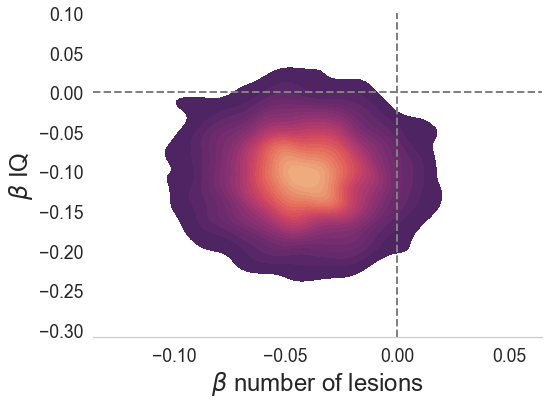

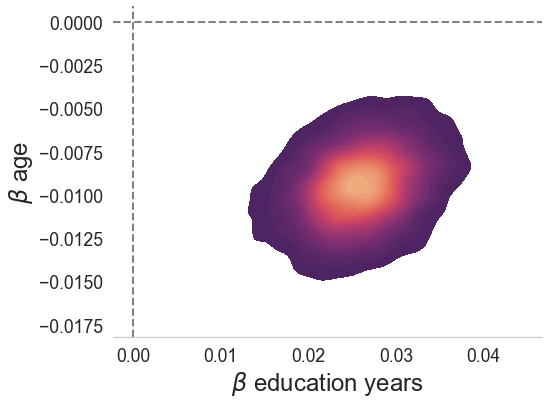

In [ ]:
# posterior density plots
sns.set(style="whitegrid",font_scale=1.6)
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.kdeplot(np.array(hierarchical_all_parcels_education_log_trace[1000:]['cov1_lesions'])[:,0],
            np.array(hierarchical_all_parcels_education_log_trace[1000:]['cov7_IQCode'])[:,0],
                     fill=True, cmap='flare_r', label="Left brain", shade_lowest=False, cbar=False,
                     gridsize=100, levels=25, thresh=0.025)
plt.axhline(y=0.0, color="grey",lw=2,ls="--")
plt.axvline(x=0.0, color="grey",lw=2,ls="--")                 
plt.grid(False)
plt.title('')
plt.xlabel(r'$\beta$'+ ' number of lesions', fontsize=24)
plt.ylabel(r'$\beta$'+ ' IQ', fontsize=24)
sns.despine(left=True)
plt.tight_layout()
plt.show()

sns.set(style="whitegrid",font_scale=1.6)
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.kdeplot(np.array(hierarchical_all_parcels_education_log_trace[1000:]['cov6_ed_years'])[:,0],
            np.array(hierarchical_all_parcels_education_log_trace[1000:]['cov2_age'])[:,0],
                     fill=True, cmap='flare_r', label="Left brain", shade_lowest=False, cbar=False,
                     gridsize=100, levels=25, thresh=0.025)
plt.axhline(y=0.0, color="grey",lw=2,ls="--")
plt.axvline(x=0.0, color="grey",lw=2,ls="--")                 
plt.grid(False)
plt.title('')
plt.xlabel(r'$\beta$'+ ' education years', fontsize=24)
plt.ylabel(r'$\beta$'+ ' age', fontsize=24)
sns.despine(left=True)
plt.tight_layout()
plt.show()

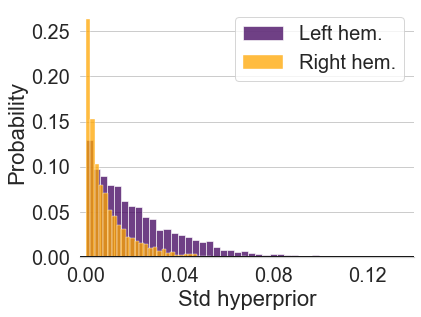

In [ ]:
# Variance left & right hemisphere
sns.set(style="whitegrid",font_scale=1.8)
fig, axs = plt.subplots(1, 1, figsize=(6, 4.6))
g1 = sns.histplot((hierarchical_all_parcels_education_log_trace[1000:]['sigma_b_all'][:,0]),
                   bins=50, color=my_colors[0], alpha=0.75, label='Left hem.', stat='probability')
g2 = sns.histplot((hierarchical_all_parcels_education_log_trace[1000:]['sigma_b_all'][:,1]),
                   bins=50, color=my_colors[1], alpha=0.75, label='Right hem.', stat='probability')
plt.legend(fontsize=20, loc="upper right")
plt.grid(visible=False)
plt.xlim((-0.0025, 0.14))
axs.set_xticks([0, 0.04, 0.08, 0.12])
sns.despine(left=True, bottom=False)
g2.set_xlabel("Std hyperprior", fontsize=22)
g2.set_ylabel("Probability", fontsize=22)
axs.yaxis.grid()
g2.set_title('')
plt.axhline(y=0.0, color="black",lw=3,ls="-")
plt.show()